In [8]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
import gensim
from gensim.summarization import summarize


ModuleNotFoundError: No module named 'gensim.summarization'

In [2]:
fm_key = '8a1cf9d14d53126b05c8a7636fe3d006'

ticker = 'AAPL'
stock_news = requests.get(f'https://financialmodelingprep.com/api/v3/stock_news?tickers={ticker}&limit=100&apikey={fm_key}').json()
stock_news = pd.DataFrame(stock_news)
stock_news = stock_news[stock_news['site'].isin(['24/7 Wall Street', 'CNBC', 'Forbes', 'Barrons', 'Market Watch'])]

text_str = ' '.join(str(x) for x in stock_news['text'])

print(text_str)

Apple VP of environment Lisa Jackson said she expects to discuss Biden's infrastructure bill at a meeting on Apple's campus with EPA head Michael Regan. As corporations set net-zero carbon goals, getting there means tackling Scope 3 emissions, and progress on that challenge has climate experts worried. The company told staff in a memo that it will double the amount of test kits sent to staff for weekly testing. British Columbia Investment Management raised stakes in Apple, Microsoft, and Shopify, and initiated a stake in marijuana stock Tilray in the second quarter. A U.K. regulator signaled it may seek to unwind Facebook's $400 million acquisition of Giphy in the latest unfavorable regulatory development for Big Tech. App developers have complained to Congress of unfair treatment by Apple and Google. Senators introduced a bipartisan bill Wednesday that seeks to rein in the control Google and Apple Inc. have over their respective mobile-app stores, part of a larger wave of antitrust le

### 1. Summerization

In [3]:
import gensim
from gensim.summarization import summarize

text_summ = summarize(text_str)
print(text_summ)

C:\Users\jizha\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


ModuleNotFoundError: No module named 'gensim.summarization'

In [ ]:
plt.figure(figsize = (10, 10))
sum_plot = text_summ.split(' .\n')
for i in range(len(sum_plot)):
    plt.text(0.1, 1 - (i+1)*0.5, sum_plot[len(sum_plot)-1-i], size = 30,\
             horizontalalignment='center', verticalalignment='center')
    
plt.axis('off')
plt.show()

### 2. Extraction with importance:   
- Refer to: https://medium.com/analytics-vidhya/sentence-extraction-using-textrank-algorithm-7f5c8fd568cd

In [42]:
import re
from pprint import pprint

import numpy as np
from nltk import sent_tokenize, word_tokenize

from nltk.cluster.util import cosine_distance

MULTIPLE_WHITESPACE_PATTERN = re.compile(r"\s+", re.UNICODE)

def normalize_whitespace(text):
    """
    Translates multiple whitespace into single space character.
    If there is at least one new line character chunk is replaced
    by single LF (Unix new line) character.
    """
    return MULTIPLE_WHITESPACE_PATTERN.sub(_replace_whitespace, text)


def _replace_whitespace(match):
    text = match.group()

    if "\n" in text or "\r" in text:
        return "\n"
    else:
        return " "
    

def is_blank(string):
    """
    Returns `True` if string contains only white-space characters
    or is empty. Otherwise `False` is returned.
    """
    return not string or string.isspace()


def get_symmetric_matrix(matrix):
    """
    Get Symmetric matrix
    :param matrix:
    :return: matrix
    """
    return matrix + matrix.T - np.diag(matrix.diagonal())


def core_cosine_similarity(vector1, vector2):
    """
    measure cosine similarity between two vectors
    :param vector1:
    :param vector2:
    :return: 0 < cosine similarity value < 1
    """
    return 1 - cosine_distance(vector1, vector2)

class TextRank4Sentences():
    
    def __init__(self):
        self.damping = 0.85  # damping coefficient, usually is .85
        self.min_diff = 1e-5  # convergence threshold
        self.steps = 100  # iteration steps
        self.text_str = None
        self.sentences = None
        self.pr_vector = None

    def _sentence_similarity(self, sent1, sent2, stopwords=None):
        if stopwords is None:
            stopwords = []

        sent1 = [w.lower() for w in sent1]
        sent2 = [w.lower() for w in sent2]

        all_words = list(set(sent1 + sent2))

        vector1 = [0] * len(all_words)
        vector2 = [0] * len(all_words)

        # build the vector for the first sentence
        for w in sent1:
            if w in stopwords:
                continue
            vector1[all_words.index(w)] += 1

        # build the vector for the second sentence
        for w in sent2:
            if w in stopwords:
                continue
            vector2[all_words.index(w)] += 1

        return core_cosine_similarity(vector1, vector2)
    
    def _build_similarity_matrix(self, sentences, stopwords=None):
        # create an empty similarity matrix
        sm = np.zeros([len(sentences), len(sentences)])

        for idx1 in range(len(sentences)):
            for idx2 in range(len(sentences)):
                if idx1 == idx2:
                    continue

                sm[idx1][idx2] = self._sentence_similarity(sentences[idx1], sentences[idx2], stopwords=stopwords)

        # Get Symmeric matrix
        sm = get_symmetric_matrix(sm)

        # Normalize matrix by column
        norm = np.sum(sm, axis=0)
        sm_norm = np.divide(sm, norm, where=norm != 0)  # this is to ignore the 0 element in norm

        return sm_norm

    def _run_page_rank(self, similarity_matrix):

        pr_vector = np.array([1] * len(similarity_matrix))

        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr_vector = (1 - self.damping) + self.damping * np.matmul(similarity_matrix, pr_vector)
            if abs(previous_pr - sum(pr_vector)) < self.min_diff:
                break
            else:
                previous_pr = sum(pr_vector)

        return pr_vector
    
    def _get_sentence(self, index):

        try:
            return self.sentences[index]
        except IndexError:
            return ""

    def get_top_sentences(self, number=5):

        top_sentences = {}

        if self.pr_vector is not None:

            sorted_pr = np.argsort(self.pr_vector)
            sorted_pr = list(sorted_pr)
            sorted_pr.reverse()

            index = 0
            for epoch in range(number):
                #print (str(sorted_pr[index]) + " : " + str(self.pr_vector[sorted_pr[index]]))
                sent = self.sentences[sorted_pr[index]]
                sent = normalize_whitespace(sent)
                top_sentences[sent] = self.pr_vector[sorted_pr[index]]
                index += 1

        return top_sentences
    
    def analyze(self, text, stop_words=None):
        self.text_str = text
        self.sentences = sent_tokenize(self.text_str)

        tokenized_sentences = [word_tokenize(sent) for sent in self.sentences]

        similarity_matrix = self._build_similarity_matrix(tokenized_sentences, stop_words)

        self.pr_vector = self._run_page_rank(similarity_matrix)
        
        #print(self.pr_vector)

tr4sh = TextRank4Sentences()
tr4sh.analyze(text_str)
top_sents = tr4sh.get_top_sentences(5)
top_sents

{"Apple's new system, which is in testing in the U.S. now, was also vociferously opposed by privacy advocates who warned it represents a slippery slope Xiaomi's sales grew 26% on-month, giving the company a 17.1% share of the total number of smartphones sold globally in June, Counterpoint Research said.": 1.3284366163607064,
 'Senators introduced a bipartisan bill Wednesday that seeks to rein in the control Google and Apple Inc. have over their respective mobile-app stores, part of a larger wave of antitrust legislation in congress.': 1.3086640058186756,
 'Affirm plans to offer the option to pay off iPhones, Macs, and iPads over an extended period in Canada, according to a Bloomberg report.': 1.239606317022203,
 'British Columbia Investment Management raised stakes in Apple, Microsoft, and Shopify, and initiated a stake in marijuana stock Tilray in the second quarter.': 1.210883945962737,
 'Apple Inc. plans to focus on camera upgrades, particularly around video, with its next iPhone la

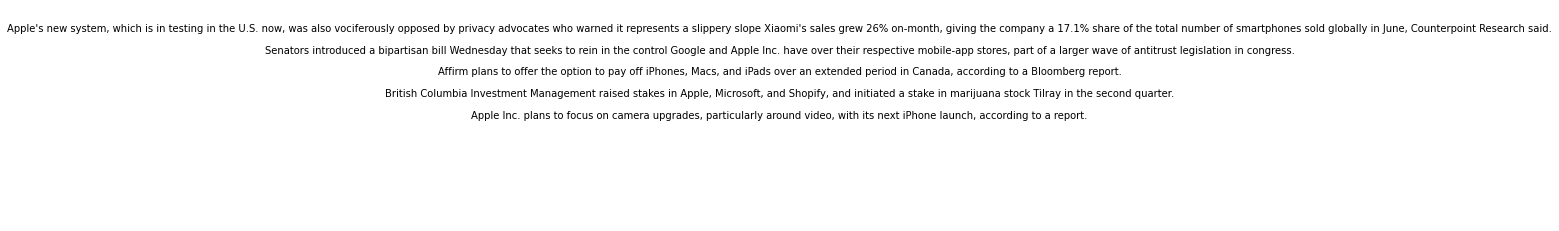

In [43]:
i = 1
for key in top_sents:
    plt.text(0.1, 1- i*0.1, key, horizontalalignment='center', verticalalignment='center')
    i = i + 1

plt.axis('off')
plt.show()

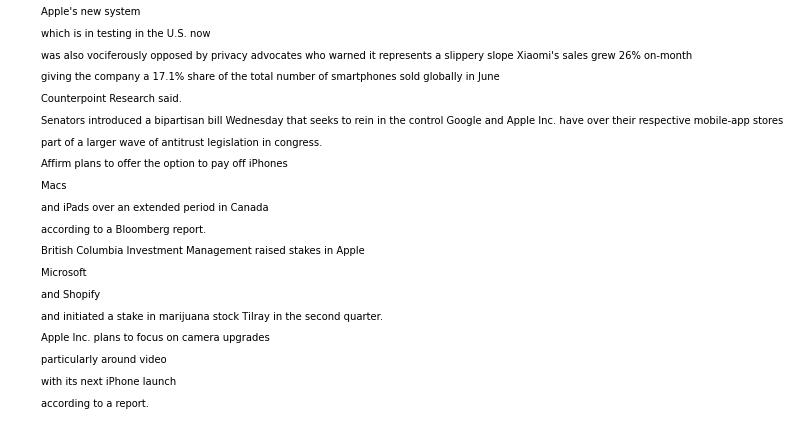

In [44]:
test = ', '.join(str(key) for key in top_sents)
# print(test)

test = test.split(', ')
# print(test)

for i in range(len(test)):
    plt.text(0.1, (i+1)*0.1, test[len(test)-1-i])
    
plt.axis('off')
plt.show()

### Plot:

In [45]:
# from io import BytesIO

# from matplotlib.figure import Figure
# import matplotlib.pyplot as plt
# from matplotlib.transforms import IdentityTransform

# def text_to_rgba(s, *, dpi, **kwargs):
#     # To convert a text string to an image, we can:
#     # - draw it on an empty and transparent figure;
#     # - save the figure to a temporary buffer using ``bbox_inches="tight",
#     #   pad_inches=0`` which will pick the correct area to save;
#     # - load the buffer using ``plt.imread``.
#     #
#     # (If desired, one can also directly save the image to the filesystem.)
#     fig = Figure(facecolor="none")
#     fig.text(0, 0, s, **kwargs)
#     buf = BytesIO()
#     fig.savefig(buf, dpi = dpi, format = "png", bbox_inches = "tight", pad_inches = 0)
#     buf.seek(0)
#     rgba = plt.imread(buf)
#     return rgba

# fig = plt.figure(figsize = (10,8))
# rgba_temp = text_to_rgba(r"what", color="blue", fontsize=20, dpi=200)
# fig.figimage(rgba_temp, 100, 50)
# fig.text(100, 350, r"some other string", color="red", fontsize=20, transform=IdentityTransform())
# plt.show()

In [46]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt

# wc = WordCloud(width = 6400, height = 6400,\
#                background_color = None, mode = "RGBA", min_font_size = 18).generate_from_frequencies(top_sents)
# plt.figure(figsize = (20, 20))
# plt.imshow(wc)
# plt.axis('off')
# plt.show()

In [47]:
# from PIL import Image, ImageDraw

# img = Image.new('RGB', (1600, 1600), color = (255, 255, 255))
# d = ImageDraw.Draw(img)

# t = 1
# for key in top_sents:
#     d.text((20*t, 20*t), str(key), fill=(255, 0, 0))
#     t += 1
    
# img.show()

In [48]:
tickers = requests.get(f'https://financialmodelingprep.com/api/v3/sp500_constituent?apikey={fm_key}').json()
tickers = pd.DataFrame(tickers)
tickers = tickers.loc[:,'symbol'].to_list()

In [50]:
for ticker in tickers[0:30]:
    stock_news = requests.get(f'https://financialmodelingprep.com/api/v3/stock_news?tickers={ticker}\
    &limit=100&apikey={fm_key}').json()
    stock_news = pd.DataFrame(stock_news)
    stock_news = stock_news[stock_news['site'].isin(['24/7 Wall Street', 'CNBC',\
                                                     'Forbes', 'Barrons', 'Market Watch'])]

    text_str = ' '.join(str(x) for x in stock_news['text'])
    print('Original:' + '(' + str(len(text_str.split('. '))) + ')' + '\n' + text_str + '\n')
    
    
    text_summ = summarize(text_str)
    print('After summarization:' + '(' + str(len(text_summ.replace('.\n', '. ').split('. '))) + ')' + '\n' + text_summ + '\n\n')
    

Original:(7)
Following a solid performance in Q2, 3M raised its full year outlook for sales to increase 7-10% and adjusted earnings to be in the range of $9.70-$10.10 per share. 3M Co. is betting on growing sales for the second half of the year, based on a strong first half that included an uptick in sales of automotive products as well as office supplies and home improvement items. 3M increases earnings outlook after topping Q2 forecasts This week of June-quarter earnings results ends with Friday morning's reports from, among others, American Express, Honeywell and Schlumberger. 3M Company is scheduled to report its Q2 2021 results on Tuesday, July 27. We expect 3M to likely post revenue and earnings above the street expectations, driven by a rebound in the overall economic activity, as global Covid-19 vaccination rates continue to rise. Trefis expects 3M's (NYSE:MMM) Safety & Industrial Revenues to grow from around $11 billion in 2020 to over $12 billion in 2021 and $12.5 billion in 

Original:(23)
Adobe's stock rose by 4.8% to $626 in the last twenty-one trading days. In comparison, the broader S&P500 rose by 1.7% over the last twenty-one trading days. Walmart Inc. said early Wednesday that it has partnered with Adobe Inc. to bring its technology to other businesses. Walmart has built new capabilities to serve its customers, and its integrating its marketplace, online and in-store fulfillment with Adobe Commerce, which will allow other retailers to use Walmart's cloud-based services for pickup, delivery and other services. The stock market is an ever-evolving giant that over the years has taken on many new forms. Online sales in the U.S. during Amazon's 48-hour Prime Day event have topped record levels of e-commerce spending during Cyber Monday, according to a report. The first day of Amazon's 48-hour Prime Day event is expected to have driven the most online sales in a 24-hour period so far this year, according to new data. Stocks are down for the fifth straight d

Original:(11)
Air Products & Chemicals Inc. APD, +0.73% reported Monday fiscal third-quarter profit that came up short of expectations while revenue beat, and lowered the midpoint of its full-year outlook. The industrial gases company's stock was still inactive in premarket trading. Our theme of Hydrogen Economy Stocks includes the stocks of U.S. listed companies that sell hydrogen fuel cells, related renewable energy equipment, and supply hydrogen gas. While the theme is up by a solid 214% since the end of 2019, compared to a return of about 36% for the S&P 500. With the trading day about halfway over, the markets were sliding lower to close out the week. Air Products & Chemicals Inc. reported Monday a fiscal second-quarter profit that came up short of expectations, while sales beat forecasts, as the COVID-19 pandemic and a severe winter storm in the U.S. Gulf Coast weighed on results. The industrial gases company's stock was still inactive in premarket trading.

After summarization:(

Original:(1)


After summarization:(1)



Original:(1)


After summarization:(1)



Original:(1)


After summarization:(1)



Original:(1)


After summarization:(1)



Original:(14)
Most investors are not aware that Street Earnings suffer from significant flaws when compared to Core Earnings. Allstate Corp. said late Tuesday it has agreed to buy SafeAuto for about $300 million, including $270 million cash and about $30 million in pre-close dividends of some non-insurance assets. Privately held SafeAuto of Columbus, Ohio, provides state-minimum private-passenger auto insurance with coverage options in 28 states, the company said. After 1Q21 earnings, we still love these three Long Ideas that have excellent profit growth opportunities and attractive risk/reward. With the trading day about halfway over, the broad markets were somewhat mixed. The Dow Jones industrial average and S&P 500 each posted a handy gain, while the Nasdaq was barely in the red. Allstate expects to book $4 billion lo

Original:(1)


After summarization:(1)



Original:(29)
Shares of airline companies traded mostly lower Monday, as travel demand has been hurt by the continued surge in new COVID-19 cases brought on by the spread of the highly infectious delta variant. The Dow added 60 points, or 0.2%, while the S&P 500 gained about 0.1% and the Nasdaq trades around the flatline. Find opportunities in this market with today's best short plays from Q.ai's deep learning algorithms. The airline mask mandate is scheduled to expire in September, and some in the airline industry agree with this though others feel it should be extended. For airline stocks, sentiment matters more than technical levels, says JC O'Hara of MKM Partners. An uptick in domestic air travel, mostly related to leisure travel, has stalled, Citi analyst Stephen Trent said in a note Wednesday. "The booking curve over the last seven days shows weaker U.S. domestic trends vs. American Airlines and Spirit Airlines suffered hundreds of delays